In [3]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
import matplotlib 

from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm


### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

from scipy.optimize import curve_fit


In [8]:
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/CACloudResiduals/'
respath  = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/'
CA_meta = Table(fits.open(CAresdir + 'CA_meta.fits')[1].data)

tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

stars_addon = stars['APOGEE_ID', 'SFD_EBV', 'SNR', 'ASPCAPFLAG', 'STARFLAG', 'ASPCAP_CHI2']
CA_meta['DIST'] = 1000 / CA_meta['GAIAEDR3_PARALLAX']

CA_meta = join(CA_meta, stars_addon, keys = 'APOGEE_ID', join_type = 'left',)

In [9]:
lambda0 = 15272.42

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()



def resample_interp(data, rv, resample_wavelengths = wavs):
    wavs_rv = get_wavs(rv = rv)
    interp = interp1d(wavs_rv, data, kind = 'slinear', bounds_error = False)
    
    data_interp = interp(resample_wavelengths)
    
    return data_interp


window = (wavs > lambda0-25) & (wavs < lambda0 + 25)
wavs_window = wavs[window]
window_fit = ((wavs > lambda0-25) & (wavs < lambda0 - 8)) | ((wavs > lambda0 + 8) & (wavs < lambda0 + 25))
wavs_fit = wavs[window_fit]

In [10]:
def star_bitmask(mask, flags, tab = stars):
    mask = np.array(mask)
    flags = np.array(flags)
    return np.all(np.bitwise_and(mask, 2**flags[:, np.newaxis]) == 0, axis = 0) #returns all are ok!

# ASPCAPFLAG: STAR_BAD (23), CHI2_BAD, METALS_BAD (19), ALPHAFE_BAD (20)
aspcapflags_list = [23, 24, 19, 20]
aspcapflagged = star_bitmask(CA_meta['ASPCAPFLAG'], aspcapflags_list)

# STARFLAG: VERY_BRIGHT_NEIGHBOR (3), PERSIST_HIGH (9) SUSPECT_RV_COMBINATION (16), SUSPECT_BROAD_LINES (17)
starflags_list = [3, 9, 16, 17]
starflagged = star_bitmask(CA_meta['STARFLAG'], starflags_list)
    

In [11]:
def line(x, m, b):
    return m * x + b 

In [17]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def get_aspcap_path(telescope = None, field = None, sourceid = None, row = None):
    if row is not None:
        telescope, field, sourceid = (np.array(row['TELESCOPE'], dtype = str), np.array(row['FIELD'], dtype = str), 
                                      np.array(row['APOGEE_ID'], dtype = str))
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

def get_apstar_path(telescope = None, field = None, fname = None, hdulist = None):
    if hdulist is not None:
        telescope, field, fname = (str(hdulist[4].data['TELESCOPE'][0]),str(hdulist[4].data['FIELD'][0]),str(hdulist[4].data['FILE'][0]))
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    path = (specdir + fname).format(TELESCOPE = telescope, FIELD = field)
    return path

In [4]:


# for i in range(0, len(CA_meta), 4):
#     star = CA_meta[i]
#     r = fits.open(get_ca_res(star['FILE']))
#     res = r[1].data[window]
#     res_uncorr = r[2].data[window]
#     fig, ax = plt.subplots()

#     label = ''
#     flag1 = aspcapflagged[i] == False
#     flag2 = starflagged[i] == False
#     if flag1:
#         label = label + ' ASPCAPFLAG '
#     if flag2:
#         label = label + ' STARFLAG '
    
#     fit_data = np.copy(r[1].data[window_fit])
#     fit_data[np.isnan(fit_data)] = 1
#     fit_params = curve_fit(line, wavs_fit, fit_data, p0 = [0, 1], 
#                            bounds = ((-0.01, 0.01), (0.99, 1.01)), check_finite = False)[0]


#     ax.fill_between([lambda0-15, lambda0-8], [1.05, 1.05], [0.9, 0.9], color = 'grey', alpha = 0.5)
#     ax.fill_between([lambda0+8, lambda0+15], [1.05, 1.05], [0.9, 0.9], color = 'grey', alpha = 0.5)

#     ax.plot(wavs_window, res, c='k', label = label)
#     # ax.plot(wavs_window, res_uncorr, c = 'r', linestyle = 'dashed')


#     avg_continuum = np.nanmedian(fit_data)
#     print(avg_continuum)
#     ax.plot([15245, 15295], [avg_continuum, avg_continuum], linestyle = 'dashed')
#     ax.plot([15245, 15295], [fit_params[1], fit_params[1]], linestyle = 'dotted')


#     ax.set_xlabel('Wavelength ($\AA$)')
#     ax.set_ylim(.9, 1.05)
#     ax.legend()
#     plt.show()

In [13]:
meta = Table(fits.open('/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/meta.fits')[1].data)
def get_medres(teff, logg, m_h, medres_dir = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/Residuals/'):
    rowselect = np.where(np.logical_and.reduce(
                    [teff >= meta['TEFF_MIN'], teff < meta['TEFF_MAX'], 
                    logg >= meta['LOGG_MIN'], logg < meta['LOGG_MAX'],
                   m_h >= meta['M_H_MIN'], m_h < meta['M_H_MAX']]))[0]
    
    row = meta[rowselect]
    filename = row['FNAME'].item()
    return medres_dir + filename



In [14]:
def continuum_shift(data):
    data_fit = np.copy(data[window_fit])
    offset = np.nanmedian(data_fit) - 1
    if np.abs(offset) < 0.02: 
        return offset
    else:
        return 0

In [30]:
new_res_path = "/uufs/astro.utah.edu/common/home/u1371365/Data/20230420_CAResiduals/"
shifts = np.zeros(len(CA_meta))
for i in range(len(CA_meta)):
    star = CA_meta[i]
    id = star['APOGEE_ID']

    
    res = fits.open(get_ca_res(star['FILE']))

 
    aspcap = fits.open(get_aspcap_path(row = star))
    apstar = fits.open(get_apstar_path(hdulist = aspcap))
    medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))


    residual_unshifted = res[1].data
    shift = continuum_shift(residual_unshifted)
    shifts[i] = shift
    residual = (residual_unshifted - shift).astype(float)

    aspcap_err_interpolated = resample_interp(aspcap[2].data, rv = star['VHELIO_AVG']).astype(float)
    apstar_mask = apstar[3].data[0, :].astype(int)
    med_residual = medres[1].data
    med_residual_err = medres[3].data


    if med_residual is None:
        nan_base = np.zeros(residual_unshifted.shape)
        nan_base[:] = np.nan
        med_residual = np.copy(nan_base)
        med_residual_err = np.copy(nan_base)
    if (med_residual.shape != residual_unshifted.shape):
        nan_base = np.zeros(residual_unshifted.shape)
        nan_base[:] = np.nan
        med_residual = np.copy(nan_base)
        med_residual_err = np.copy(nan_base)

    rest_frame_data = np.array([aspcap[1].data, aspcap[2].data, aspcap[3].data, apstar_mask, med_residual, med_residual_err]).astype(float)

    

    hdu0 = fits.PrimaryHDU()
    hdu1 = fits.ImageHDU(residual)
    hdu2 = fits.ImageHDU(aspcap_err_interpolated)
    hdu3 = fits.ImageHDU(rest_frame_data)


    labels = ['Corrected residual', 'Interpolated error', 'Base data']
    base_labels = ['aspcap_spec, aspcap_err, aspcap_model, apstar_mask, med_res, med_res_errs']
    frame = ['Observed', 'Observed', 'Rest']

    for i, hdu in enumerate([hdu1, hdu2, hdu3]):
        hdu.header['LABEL'] = labels[i]
        hdu.header['FRAME'] = frame[i]

    hdu1.header['SHIFT'] = shift
    hdul = fits.HDUList([hdu0, hdu1, hdu2, hdu3])

    filename = new_res_path + 'res_{}.fits'.format(id)
    hdul.writeto(filename, overwrite = True)

CA_meta['CONT_SHIFT'] = shifts
CA_meta.write(new_res_path + 'CA_meta.fits', overwrite = True)


In [33]:
vergely_integrated_ext = Table.read('../Data/Temporary/intext.csv')
# downloaded from https://explore-platform.eu/sda/instances/993f5289-b0a6-428d-9975-5335a3bd49bd_g-tomo_2d587888-d482-4348-9f3f-ae528101c6b3/
A0Coeff = 1.052180128669157 # from 02-03dustmap_explore.ipynb, calculated via dustapprox
vergely_integrated_ext['ext'] = vergely_integrated_ext['ext'] * A0Coeff
vergely_integrated_ext['ext_err']= vergely_integrated_ext['exterr'] * A0Coeff

vergely_integrated_ext['ext'].name = 'VERG_AV'
vergely_integrated_ext['exterr'].name = 'VERG_AV_ERR'

from astropy.table import hstack

CA_meta_vergav = hstack([CA_meta, vergely_integrated_ext['VERG_AV', 'VERG_AV_ERR']])
CA_meta_vergav.write(new_res_path + 'CA_meta.fits', overwrite = True)

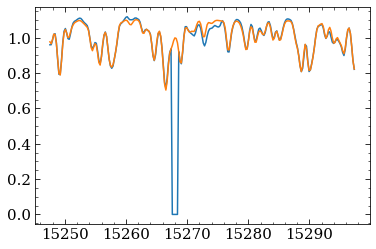

    APOGEE_ID     
------------------
2M04184151+3633397


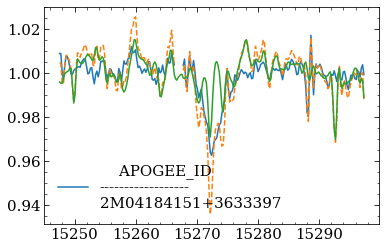

In [ ]:
example_id ='2M04184151+3633397' # '2M04212534+3948468' 
# 2M04090401+3759039
# 2M04284107+3703430
# 2M04184151+3633397


star = CA_meta[CA_meta['APOGEE_ID'] == example_id]

fname = '/uufs/astro.utah.edu/common/home/u1371365/StellarResidualsSpring2022/CACloudResiduals/res_{}.fits'.format(example_id)
res = fits.open(fname)


aspcap = fits.open(get_aspcap_path(row = star[0]))
apstar = fits.open(get_apstar_path(hdulist = aspcap))
medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))


plt.plot(wavs_window, aspcap[1].data[window])
plt.plot(wavs_window, aspcap[3].data[window])
plt.show()

plt.plot(wavs_window, res[1].data[window], label = star['APOGEE_ID'])
plt.plot(wavs_window, res[2].data[window], linestyle = 'dashed')
plt.plot(wavs_window, resample_interp(medres[1].data, star['VHELIO_AVG'])[window])

print(star['APOGEE_ID'])
plt.legend()
plt.show()

# residual = res[1].data
# aspcap_err_interpolated = resample_interp(aspcap[2].data, rv = CA_meta['VHELIO_AVG'])
# apstar_mask = apstar[3].data
# med_residual = medres[1].data
# med_residual_err = medres[3].data


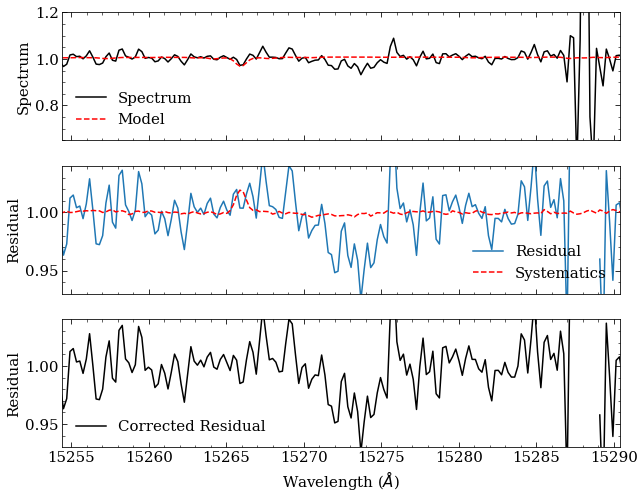

In [24]:
fig, axs = plt.subplots(nrows = 3, ncols =1, sharex = True, figsize = (10, 8))
bitmask = np.bitwise_and(apstar[3].data[0], 2**0)
spectrum = resample_interp(np.ma.array(aspcap[1].data, mask = bitmask).filled(np.nan), star['VHELIO_AVG'])
model = resample_interp(aspcap[3].data, star['VHELIO_AVG'])
axs[0].plot(wavs_window, spectrum[window], color = 'k', label = 'Spectrum')
axs[0].plot(wavs_window, model[window], color = 'r', linestyle = 'dashed', label = 'Model')
axs[0].legend(loc = 'lower left')

res_corr = res[1].data
res_uncorr = res[2].data
medres_interp = resample_interp(medres[1].data, star['VHELIO_AVG'])
axs[1].plot(wavs_window, res_uncorr[window], label = 'Residual')
axs[1].plot(wavs_window, medres_interp[window], color = 'r', linestyle = 'dashed', label = 'Systematics')
axs[1].legend()

axs[2].plot(wavs_window, res_corr[window], color = 'k', label = 'Corrected Residual')

axs[2].set_xlabel('Wavelength ($\AA$)')
axs[0].set_xlim(lambda0-18, lambda0+18)
axs[2].legend()

ymin, ymax = (0.93, 1.04)
axs[0].set_ylim(0.65, 1.2)
axs[0].set_ylabel('Spectrum')
axs[1].set_ylabel('Residual')
axs[2].set_ylabel('Residual')
axs[1].set_ylim(ymin, ymax)
axs[2].set_ylim(ymin, ymax)

fig.savefig('Example_3.png')
plt.show()



array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
for i in range(15):
    print(np.bitwise_and(16433, 2**i))


1
0
0
0
16
32
0
0
0
0
0
0
0
0
16384
